# Inpainting with style workbench (Deep Image Prior Style Transfer)
key points : 


1.   deep prior generator to synthetise the image
2.   enforce a pixel-to-pixel loss constraint on the generator output for known pixels
3. impose a style reference obtained via style transfer for unknown pixels

**the result image will be saved in the content folder**



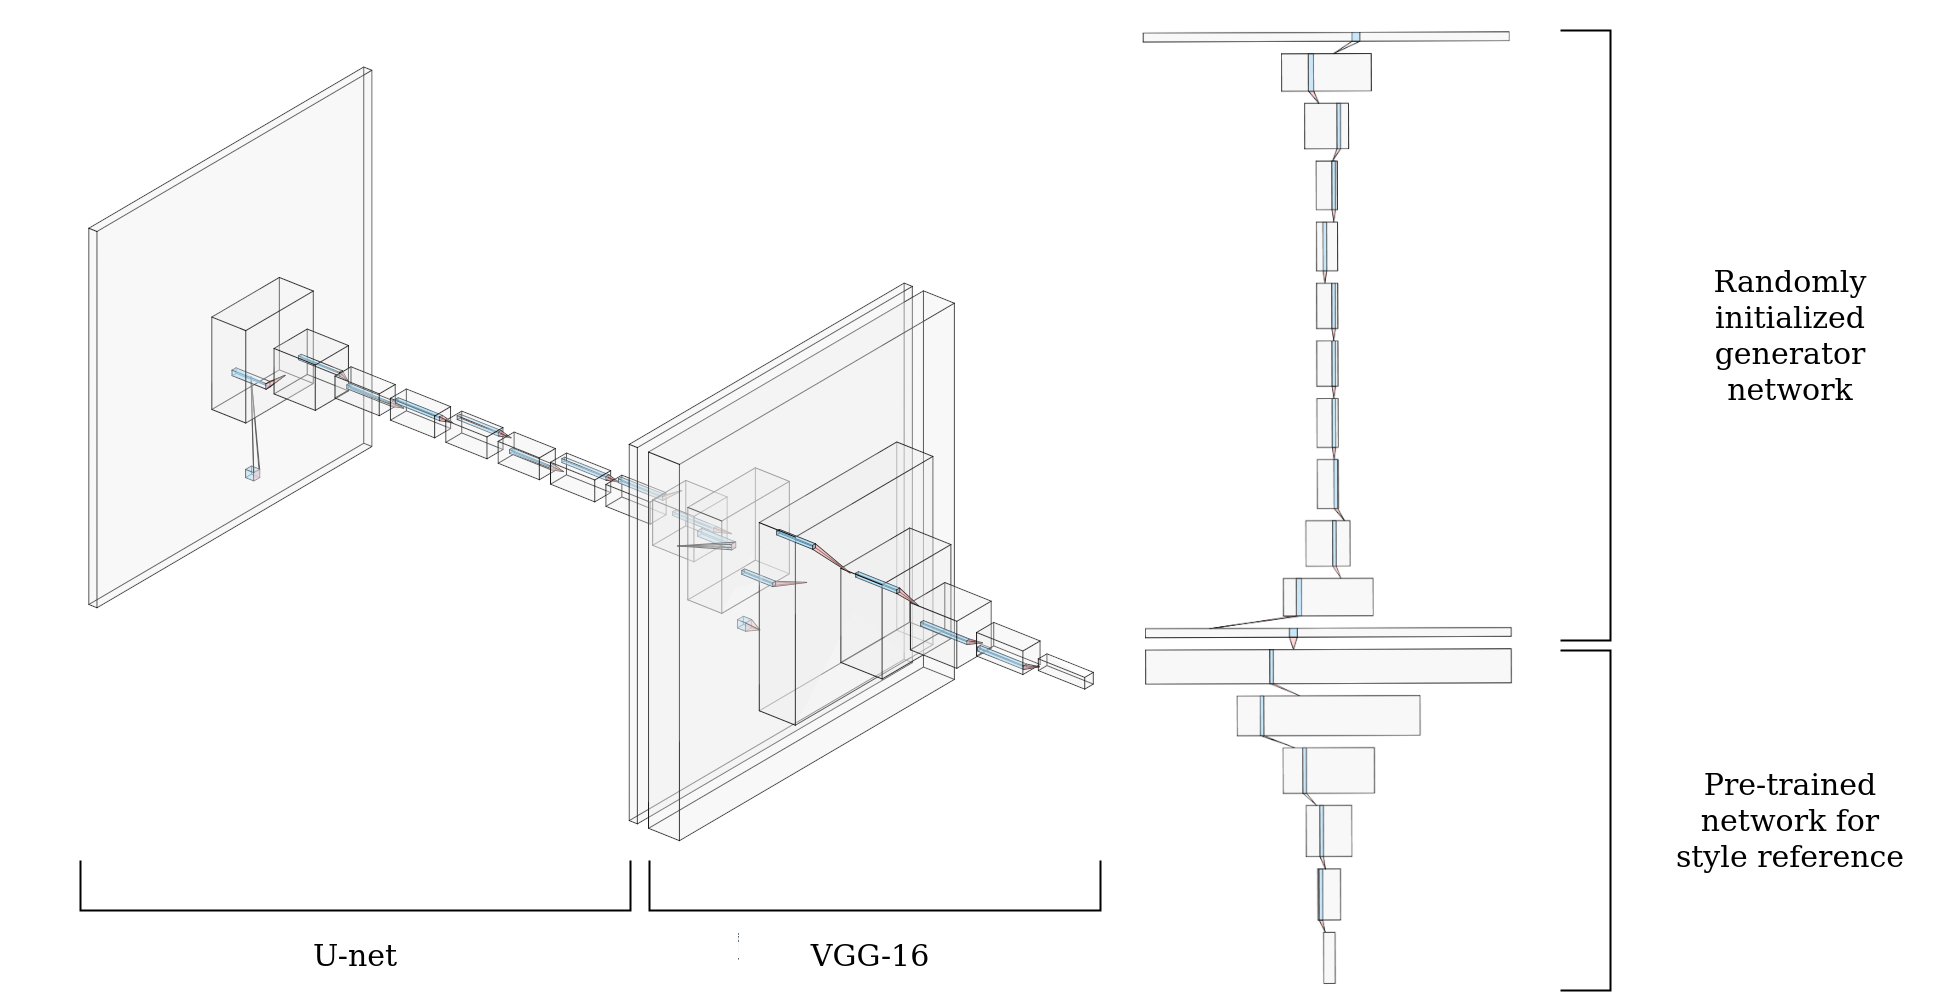

## General setup 
**setup all your parameters**


its a huge notebook, don't get lost & be careful, every image needs tuning! 

In [1]:
# cloning some sample images 
!git clone https://github.com/fmerizzi/inpainting_dataset

fatal: destination path 'inpainting_dataset' already exists and is not an empty directory.


In [2]:
#style image 
style_img_path = "/home/fmerizzi/Documents/letter_style/inpaintingA.jpg"
#style transfer content image (just for test purposes, not needed for normal use) 
content_img_path = style_img_path #"/content/small_veins1.jpg"

In [3]:
# original image to be inpainted
inpaint_original_path  = '/home/fmerizzi/Documents/letter_style/inpaintingA.jpg'
# mask for the image (2 channels!)
mask_path = '/home/fmerizzi/Documents/letter_style/inpaintingA_mask3.jpg'

In [4]:
#DEEP PRIOR SETTINGS
#input kind
INPUT =  'noise'#"meshgrid"
input_depth = 1 #2 for meshgrid
#convolution parameters 
pad = 'refection'#'zero' 
#optimizer parameters 
OPT_OVER = 'net' #'net,input,down'
#learning rate 
LR = 0.01
#Deep prior architecture
NUM_CHANNELS_DOWN=[16, 32, 64, 128, 256]
NUM_CHANNELS_UP=[16, 32, 64, 128, 256]
NUM_CHANNELS_SKIP=[0, 0, 0, 0, 0]
FILTER_SIZE_DOWN=[3,3,3,5,7]
FILTER_SIZE_UP=[3,3,3,5,7]
#param noise 
param_noise = True
#plot
show_every = 100
#reg 
reg_noise_std = 0.7

In [5]:
#STYLE TRANSFER SETTINGS 
#epochs 
STEPS = 3000 
#choose on which style layers compute the gram loss 
STYLE_LAYERS = ['conv_1','conv_2','conv_3', 'conv_4','conv_5','conv_6','conv_7', 'conv_8','conv_9', 'conv_10', 'conv_11','conv_12', 'conv_13','conv_14', 'conv_15',"conv_16"]
# type of optimizer
OPT_TYPE =  "rmsprop" #"sgd"   "RAdam" "adam""Rprop" "ASGD" "lbfgs""ASGD""Adamax"
MOMENTUM = 0 #only for SGD & rmsprop!
# pick your loss type! (both = style + deep prior, vanilla_deep = only deep prior)
#(Use this to test with/without style information)
LOSS_TYPE =  "vanilla_deep" #"both"  "only_style"
#style weight (enforcing style)
#USUALLY STYLE IS THE MOST RELEVANT PARAMETER
STYLE_WEIGHT = 0.02
#inpainting weight (enforcing inpainting mask)
INPAINT_WEIGHT = 1
#adding a TV regularization 
TV =  True#  True
TV_WEIGHT = 1

## Style Transfer init

In [6]:
%matplotlib inline

In [7]:
#imports 
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

/home/fmerizzi/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
#select gpu if possible 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# select style and content images 
style_img = image_loader(style_img_path)
content_img = image_loader(content_img_path)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

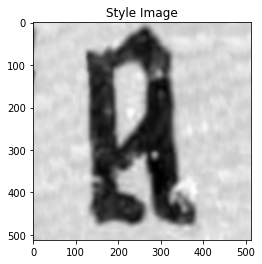

In [10]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

# tensor -> clone -> squeeze -> to PIl 
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)

    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
def imconvert(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      
    image = unloader(image)

    return image



plt.figure()
imshow(style_img, title='Style Image')

#plt.figure()
#imshow(content_img, title='Content Image (useless, just for tests')

In [11]:
#content loss simply measure the mse of a feature output of a layer 
#the computed loss is saved as a parameter of the module 
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [12]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [13]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## classification model 

In [14]:
# we get the pretrained vgg 19 (only the conv layers by selecting features)
# set up the network for evaluation
cnn = models.vgg19(pretrained=True).features.to(device).eval()

VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [16]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1','conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_9', 'conv_10', 'conv_11']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:/home/fmerizzi/Documents/Style_Transfer_Deep_Prior/DIPST_Dataset/squareCrop1_Grenouillre.jpg
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [17]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    w_variance = torch.sum(torch.pow(img[:,:,:,:-1] - img[:,:,:,1:], 2))
    h_variance = torch.sum(torch.pow(img[:,:,:-1,:] - img[:,:,1:,:], 2))
    loss = tv_weight * (h_variance + w_variance)
    return loss

## common utils

In [18]:
import torch
import torch.nn as nn
import torchvision
import sys

import numpy as np
from PIL import Image
import PIL
import numpy as np

import matplotlib.pyplot as plt

def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d, 
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2), 
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.

    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)
    
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    
    plt.show()
    
    return grid

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size. 

    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np



def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
        
    return net_input

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False

## Downsampler

In [19]:
import numpy as np
import torch
import torch.nn as nn 

class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()
        
        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'
            
            
        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch       

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1: 
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)
                
            self.padding = nn.ReplicationPad2d(pad)
        
        self.preserve_size = preserve_size
        
    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)
        
def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']
    
    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box': 
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])
    
        
    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)
        
    elif kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        
        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos': 
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                
                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor  
                    dj = abs(j + 0.5 - center) / factor 
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor
                
                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                
                kernel[i - 1][j - 1] = val
            
        
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel

## common model utils

In [20]:
import torch
import torch.nn as nn
import numpy as np

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)


class GenNoise(nn.Module):
    def __init__(self, dim2):
        super(GenNoise, self).__init__()
        self.dim2 = dim2

    def forward(self, input):
        a = list(input.size())
        a[1] = self.dim2
        # print (input.data.type())

        b = torch.zeros(a).type_as(input.data)
        b.normal_()

        x = torch.autograd.Variable(b)

        return x


class Swish(nn.Module):
    """
        https://arxiv.org/abs/1710.05941
        The hype was so huge that I could not help but try it
    """
    def __init__(self):
        super(Swish, self).__init__()
        self.s = nn.Sigmoid()

    def forward(self, x):
        return x * self.s(x)


def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()


def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)

## skip model

In [21]:
import torch
import torch.nn as nn

def skip(
        num_input_channels=2, num_output_channels=3, 
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True, 
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU', 
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.

    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1 

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)
        
        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))
            
        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model


In [22]:

import torch
import torch.optim

#from utils.feature_inversion_utils import *
#from utils.perceptual_loss.perceptual_loss import get_pretrained_net

In [23]:
dtype = torch.cuda.FloatTensor

net_input = get_noise(input_depth, INPUT, 512, noise_type='u',var=1./10).type(dtype).detach()

In [24]:
net = skip(input_depth, 3, num_channels_down = NUM_CHANNELS_DOWN,
                           num_channels_up =   NUM_CHANNELS_UP,
                           num_channels_skip = NUM_CHANNELS_SKIP,   
                           filter_size_down = FILTER_SIZE_DOWN, filter_size_up = FILTER_SIZE_UP, 
                           upsample_mode='nearest', downsample_mode='stride',need1x1_up=False,
                           need_sigmoid=True, pad=pad, need_bias=True,act_fun='LeakyReLU').type(dtype)

# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 9636083


In [25]:
#style_weight=1000000, content_weight=1):
mse = torch.nn.MSELoss().type(dtype)

## inpainting commons

In [26]:
from PIL import Image
import PIL

In [27]:
import torch
import torch.nn as nn
import torchvision
import sys

import numpy as np
from PIL import Image
import PIL
import numpy as np

import matplotlib.pyplot as plt

def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d, 
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2), 
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.
    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)
    
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    
    plt.show()
    
    return grid

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size. 
    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np



def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
        
    return net_input

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.
    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.
    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


## Prepare inpainting references

In [28]:
img_path  = inpaint_original_path
mask_path = mask_path

In [29]:
dim_div_by = 64

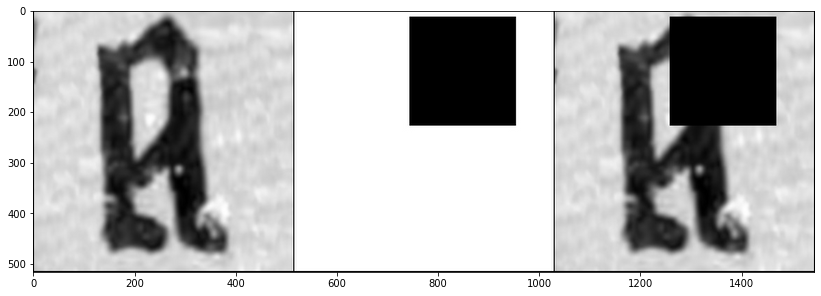

In [30]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

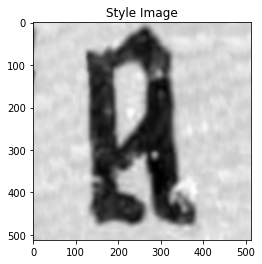

In [31]:
plt.figure()
imshow(style_img, title='Style Image')

In [32]:
img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

## Run the model

In [33]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, style_weight=1, num_steps=STEPS, content_weight=1,
                      inpainting_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    #input_img.requires_grad_(True)
    net_input_img = net(input_img)[:, :, :imsize, :imsize]
    net_input_saved = net_input_img.detach().clone()
    noise = net_input_img.detach().clone()

    p = get_params(OPT_OVER, net, net_input)
    
    model.requires_grad_(False)
    if "adam" in OPT_TYPE: 
      optimizer = optim.Adam(p,lr = LR)
    elif "lbfgs" in OPT_TYPE:
      optimizer = optim.LBFGS(p,lr = LR)
    elif "sgd" in OPT_TYPE:
      optimizer = optim.SGD(p,lr = LR,momentum=MOMENTUM)
    elif "NAdam" in OPT_TYPE:
      optimizer = optim.NAdam(p,lr = LR)
    elif "Adamax" in OPT_TYPE:
      optimizer = optim.Adamax(p,lr = LR)
    elif "RAdam" in OPT_TYPE:
      optimizer = optim.RAdam(p,lr = LR)
    elif "rmsprop" in OPT_TYPE:
      optimizer = optim.RMSprop(p,lr = LR,momentum=MOMENTUM)
    elif "ASGD" in OPT_TYPE:
      optimizer = optim.ASGD(p,lr = LR)
    else:
      raise Exception("Unknown optimizer type, check it!")

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            
            optimizer.zero_grad()
            net_input_img = net(input_img)[:, :, :imsize, :imsize]
            
            
            if param_noise:
              for n in [x for x in net.parameters() if len(x.size()) == 4]:
                n = n + n.detach().clone().normal_() * n.std() / 50
                
            net_input = net_input_saved
            if reg_noise_std > 0:
                net_input = net_input_saved + (noise.normal_() * reg_noise_std)


            model(net_input_img)

            style_score = 0
            content_score = 0
            
            # inpainting loss
            total_loss = mse(net_input_img * mask_var, img_var * mask_var)

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight
            
            #if run[0] < 400 :
            #    loss = style_score + total_loss #+ content_score 
            #else:
            #    loss = total_loss
            total_variation_loss = tv_loss(net_input_img.clone().detach(),7)
            if "both" in LOSS_TYPE:
              if TV == True: 
                loss = (style_weight*style_score) + (inpainting_weight*total_loss) + (TV_WEIGHT*total_variation_loss) #+ content_score 
              else: 
                loss = (style_weight*style_score) + (inpainting_weight*total_loss) #+ content_score 
            elif "vanilla" in LOSS_TYPE:
              if TV == True:
                loss = (inpainting_weight*total_loss) + (TV_WEIGHT*total_variation_loss) #+ content_score 
              else:
                loss = (inpainting_weight*total_loss) #+ content_score 
            elif "only_style" in LOSS_TYPE:
              if TV == True:
                loss = (style_weight*style_score) + (TV_WEIGHT*total_variation_loss)  #+ content_score 
              else:
                loss = (style_weight*style_score) #+ content_score 
            else :
              raise Exception("Unknown loss, check the tips!")

            loss.backward()

            run[0] += 1
            if run[0] % show_every == 0:
                print("total loss -> ", total_loss)
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                plt.figure(figsize=(5,5))
                imshow(net_input_img, title='Output Image')
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    return net(input_img)[:, :, :imsize, :imsize]

Finally, we can run the algorithm.




Building the style transfer model..


/tmp/ipykernel_6550/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_6550/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
total loss ->  tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)
run [100]:
Style Loss : 0.000040 Content Loss: 2.341880


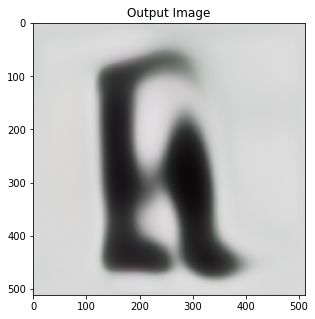


total loss ->  tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
run [200]:
Style Loss : 0.000038 Content Loss: 2.179173


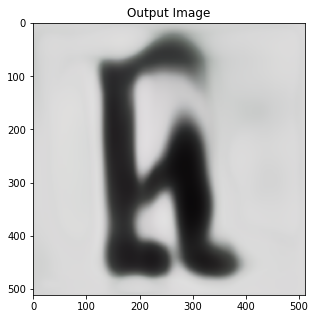


total loss ->  tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
run [300]:
Style Loss : 0.000036 Content Loss: 2.112063


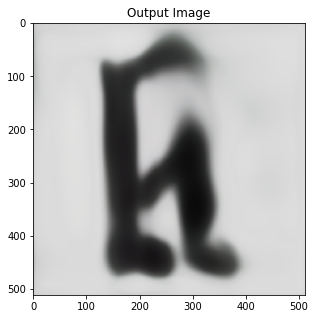


total loss ->  tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
run [400]:
Style Loss : 0.000036 Content Loss: 2.034220


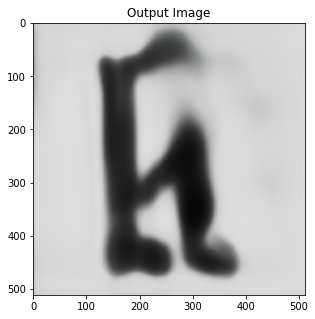


total loss ->  tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
run [500]:
Style Loss : 0.000035 Content Loss: 1.967258


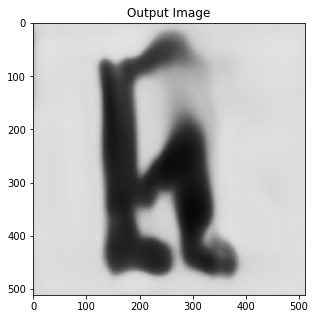


total loss ->  tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)
run [600]:
Style Loss : 0.000033 Content Loss: 1.863549


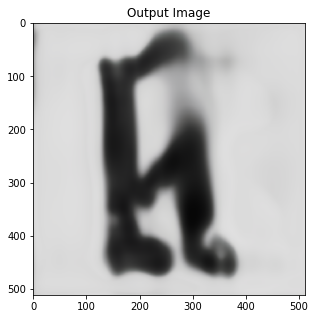


total loss ->  tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)
run [700]:
Style Loss : 0.000028 Content Loss: 1.815943


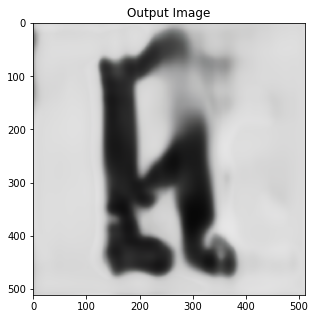


total loss ->  tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)
run [800]:
Style Loss : 0.000025 Content Loss: 1.729282


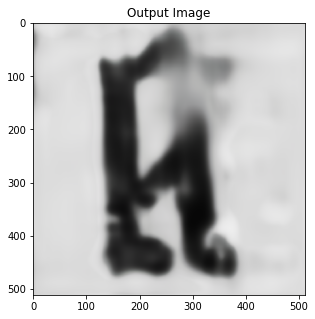


total loss ->  tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
run [900]:
Style Loss : 0.000033 Content Loss: 2.187984


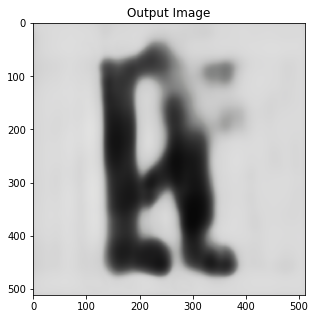


total loss ->  tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1000]:
Style Loss : 0.000022 Content Loss: 1.740510


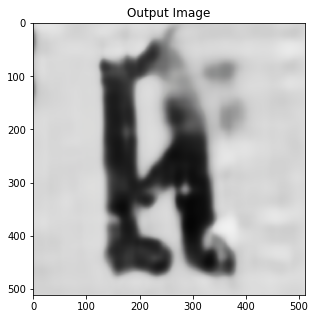


total loss ->  tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1100]:
Style Loss : 0.000018 Content Loss: 1.627681


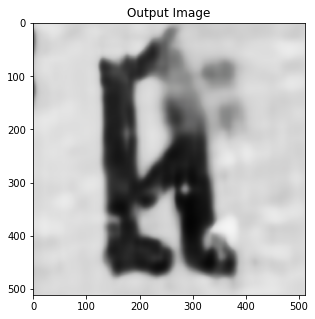


total loss ->  tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1200]:
Style Loss : 0.000031 Content Loss: 2.758487


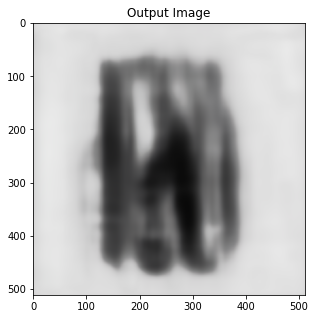


total loss ->  tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1300]:
Style Loss : 0.000015 Content Loss: 1.532730


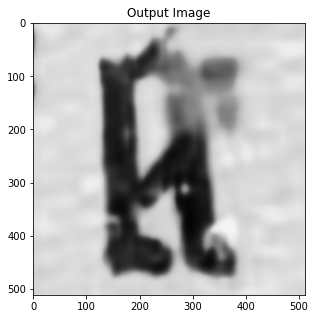


total loss ->  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1400]:
Style Loss : 0.000013 Content Loss: 1.439072


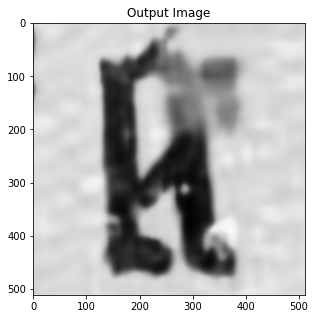


total loss ->  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1500]:
Style Loss : 0.000010 Content Loss: 1.375493


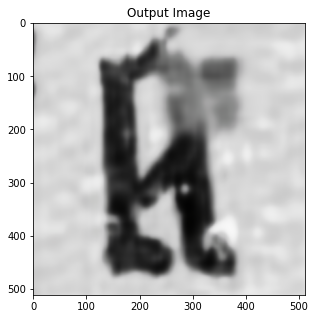


total loss ->  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1600]:
Style Loss : 0.000009 Content Loss: 1.315177


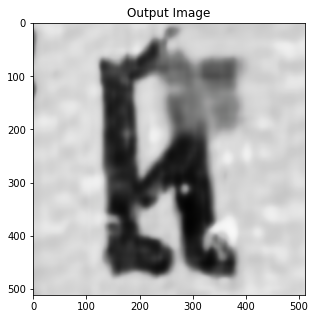


total loss ->  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1700]:
Style Loss : 0.000009 Content Loss: 1.235432


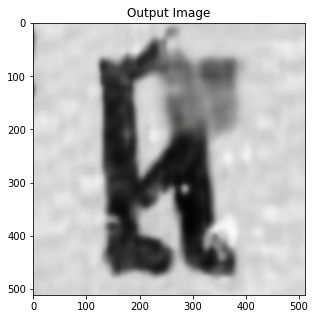


total loss ->  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1800]:
Style Loss : 0.000007 Content Loss: 1.197724


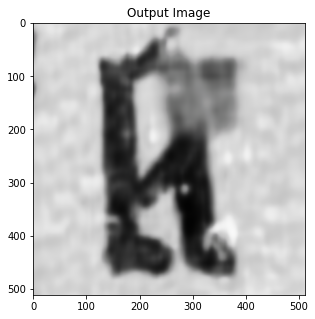


total loss ->  tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)
run [1900]:
Style Loss : 0.000021 Content Loss: 1.885551


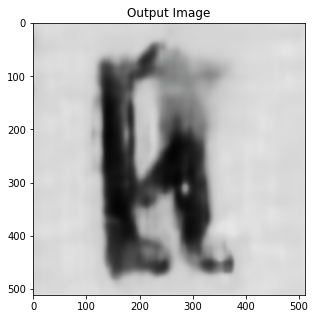


total loss ->  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2000]:
Style Loss : 0.000007 Content Loss: 1.089983


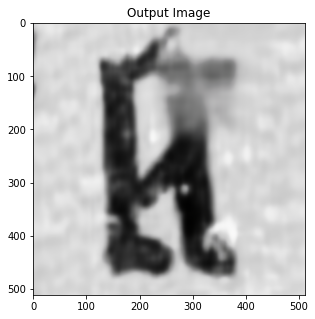


total loss ->  tensor(8.4189e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2100]:
Style Loss : 0.000007 Content Loss: 1.071080


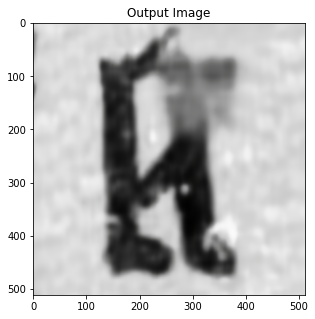


total loss ->  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2200]:
Style Loss : 0.000006 Content Loss: 1.049185


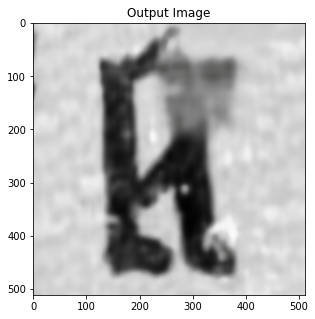


total loss ->  tensor(7.5354e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2300]:
Style Loss : 0.000006 Content Loss: 1.033739


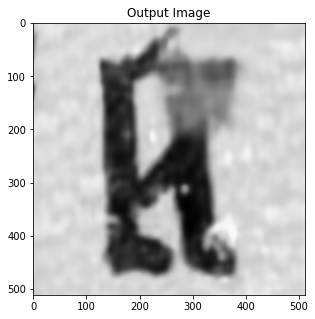


total loss ->  tensor(7.6513e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2400]:
Style Loss : 0.000006 Content Loss: 1.019472


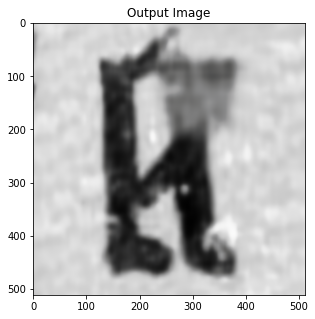


total loss ->  tensor(8.6864e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2500]:
Style Loss : 0.000005 Content Loss: 1.029100


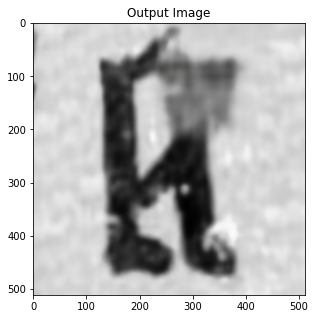


total loss ->  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2600]:
Style Loss : 0.000006 Content Loss: 0.997034


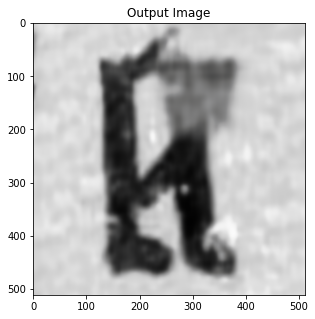


total loss ->  tensor(7.2319e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2700]:
Style Loss : 0.000006 Content Loss: 0.992390


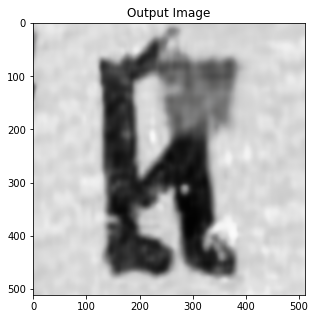


total loss ->  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2800]:
Style Loss : 0.000006 Content Loss: 1.013527


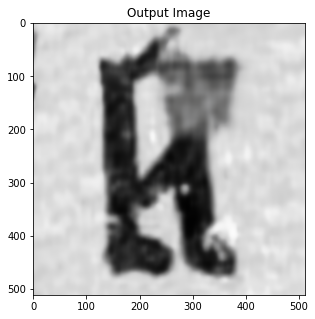


total loss ->  tensor(5.6152e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
run [2900]:
Style Loss : 0.000005 Content Loss: 0.970003


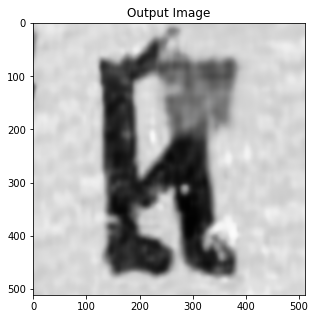


total loss ->  tensor(8.1600e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
run [3000]:
Style Loss : 0.000005 Content Loss: 0.956388


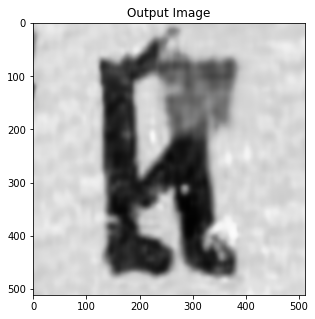

In [34]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, net_input,style_weight = STYLE_WEIGHT, inpainting_weight=INPAINT_WEIGHT)


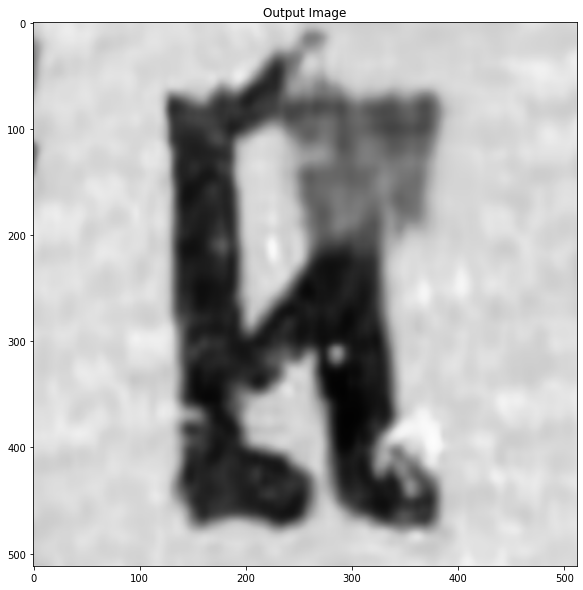

In [35]:
plt.figure(figsize=(10,10))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [36]:
from datetime import datetime

now = datetime.now()
imconvert(output).save( str(now) + "stWgh-" + str(STYLE_WEIGHT) + ".png")